__BIOBSS - Respiratory Analysis__

_This notebook includes guidelines to help using BIOBSS for respiratory signal extraction and respiratory rate estimation from PPG or ECG signal._

In [1]:
#Import BIOBSS and the other required packages

import biobss
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1.[PPG Sample Data](#sampledata)<br>
2.[Preprocessing](#resp_pre)<br>
3.[Extraction of Respiratory Signals](#resp_sig)<br>
4.[Respiratory Signal Filtering](#filt_resp)<br>
5.[Calculation of Respiratory Quality Indices](#resp_rqi)<br>
6.[Respiratory Rate Estimation](#resp_rr)<br>
7.[Fusion of Respiratory Rates](#resp_fusion)<br>

### __PPG Sample Data__
<a id="sampledata"></a>

PPG sample data is provided as a csv file in BIOBSS\sample data. The data file contains 100 PPG segments of 10-seconds length. The sampling rate is 64 Hz for all segments.

In [2]:
#Load the sample data
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"sample_data")
filename='ppg_sample_data.csv'
data=pd.read_csv(os.path.join(data_dir,filename), header=None)

#Select the first segment to be used in the example
fs=64
L=10
sig=np.asarray(data.iloc[0,:])  

### __Preprocessing__
<a id="resp_pre"></a>

For respiratory rate estimation, the PPG signal should be filtered before extracting respiratory signal(s). 'Resptools' module includes functions with predefined filtering parameters to eliminate very high and very low frequencies.

In [3]:
#ELiminate very low frequencies. 5th order Butterworth highpass filter with 0.0665 Hz (4 bpm) cutoff frequency.
filt_sig=biobss.resptools.elim_vlf(sig,fs)
#ELiminate very low frequencies. 5th order Butterworth lowpass filter with 0.5833 (35 bpm) cutoff frequency.
filt_sig=biobss.resptools.elim_vhf(sig,fs)

For the extraction of respiratory signals from modulations in the PPG signal, peak and trough locations are needed. To be able to calculate the modulations, number of peaks and troughs should match. Thus, peak control procedure should also be applied following peak detection.

In [4]:
#Peak detection
info=biobss.preprocess.peak_detection(sig,fs,'peakdet',delta=0.01)
locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

#Peak correction
info=biobss.ppgtools.peak_control(locs_peaks,peaks,locs_onsets,onsets)
locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

### __Extraction of Respiratory Signals__
<a id="resp_sig"></a>

The 'extract_resp_sig' function can be used to extract respiratory signals based on three modulation types which are Amplitude Modulation(AM), Frequency Modulation(FM) and Baseline Wander(BW). The function returns a dictionary including amplitude values and corresponding sample numbers of respiratory signals for the selected modulation types.

In [5]:
#Extract the respiratory signal related to 'AM','FM' and'BW' from the PPG signal.

info=biobss.resptools.extract_resp_sig(peaks_locs=locs_peaks,peaks_amp=peaks,troughs_amp=onsets,sampling_rate=fs,mod_type=['AM','FM','BW'],resampling_rate=10)

y_am=info['am_y']
x_am=info['am_x']

y_fm=info['fm_y']
x_fm=info['fm_x']

y_bw=info['bw_y']
x_bw=info['bw_x']

BIOBSS provides plotting functions specific to each signal type. In order to plot ACC signals, ___plot_resp___ function can be used. The signals and peaks should be provided as dictionaries, and the keys should be selected as in documentation. The plots can be generated either using __Matplotlib__ or __Plotly__. 

In [ ]:
#Generate inputs as dictionaries
signals = {'AM': {'x': x_am, 'y':y_am}, 'FM': {'x': x_fm, 'y':y_fm}, 'BW': {'x': x_bw, 'y':y_bw}}

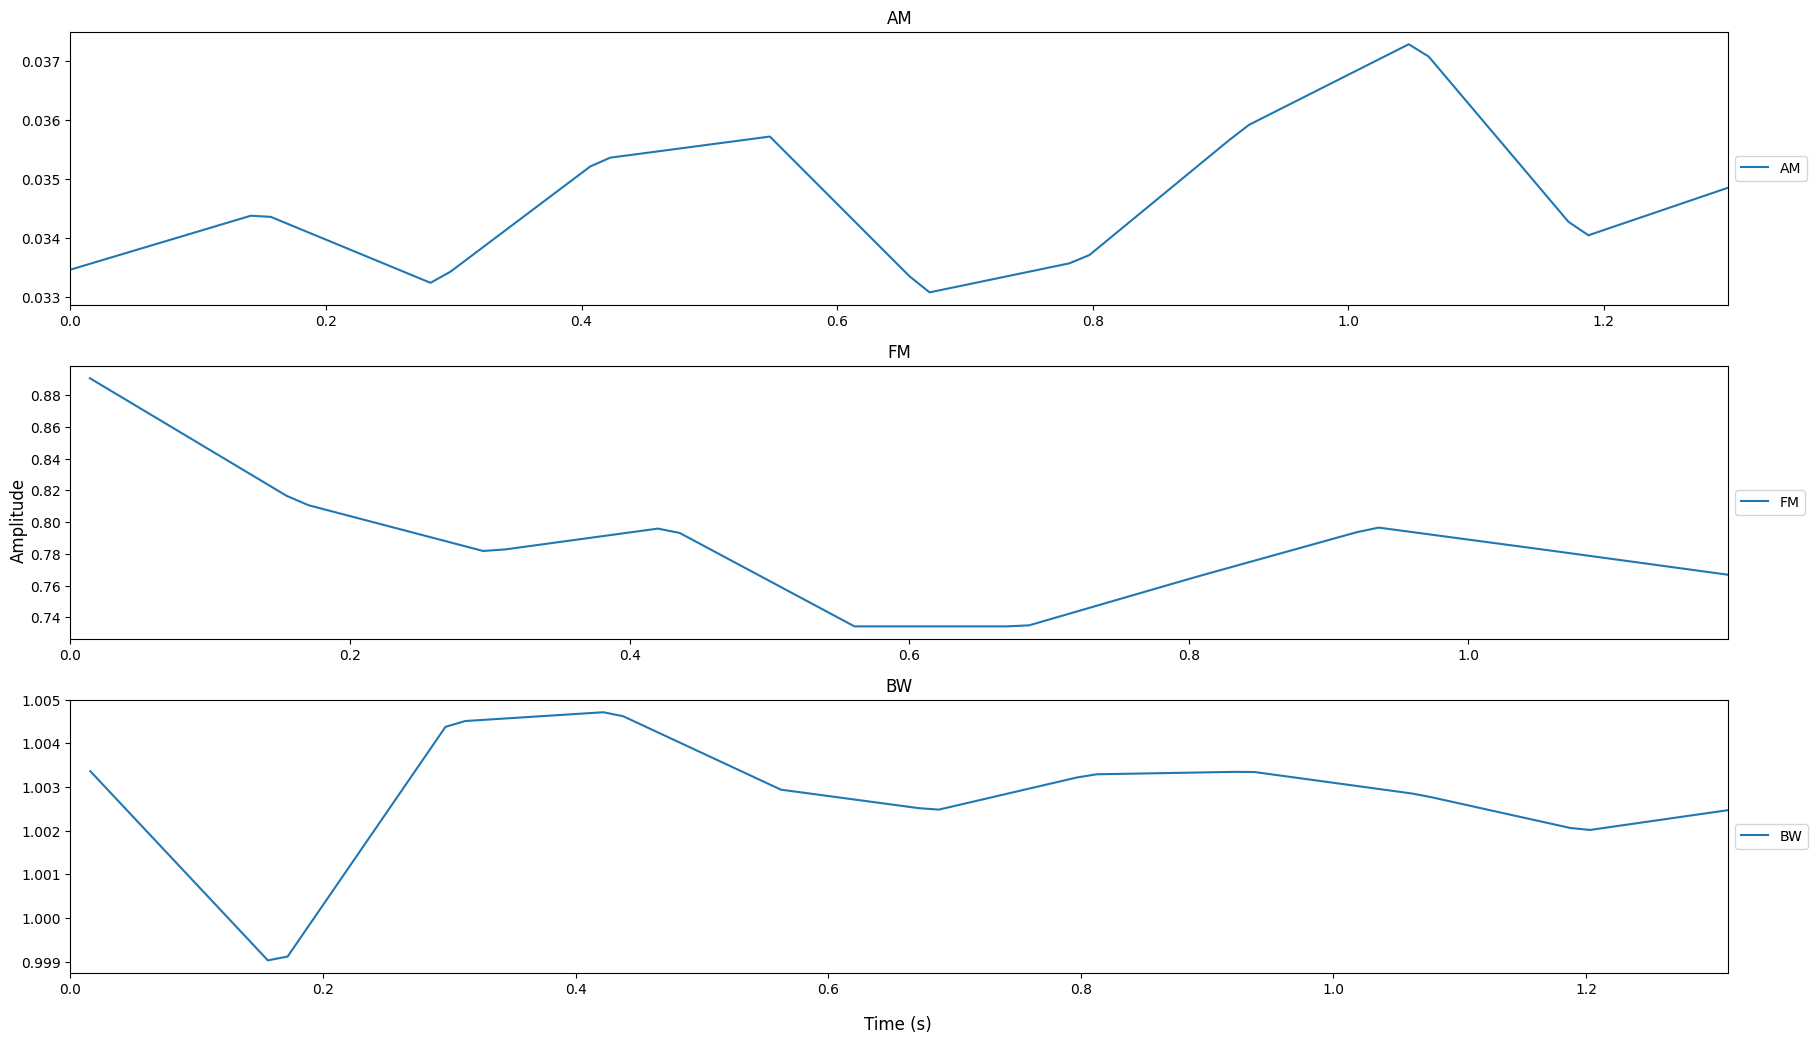

In [6]:
#Plot respiratory signals using Matplotlib
biobss.resptools.plot_resp(signals=signals, sampling_rate=fs, show_peaks=False)

In [7]:
#Plot respiratory signals using Plotly
biobss.resptools.plot_resp(signals=signals, sampling_rate=fs, method='plotly', show_peaks=False)

### __Respiratory Signal Filtering__
<a id="filt_resp"></a>

If reqıired, 'filter_resp_sig' function can be used to filter respiratory signal using neurokit's 'rsp_clean' function.

In [ ]:
#Filter respiratory signals
info=biobss.resptools.filter_resp_sig(resampling_rate=10, am_sig=y_am, am_x=x_am, fm_sig=y_fm, fm_x=x_fm, bw_sig=y_bw, bw_x=x_bw)

y_am=info['am_sig']
x_am=info['am_x']

y_fm=info['fm_sig']
x_fm=info['fm_x']

y_bw=info['bw_sig']
x_bw=info['bw_x']

### __Calculation of Respiratory Quality Indices__
<a id="resp_rqi"></a>

Quality of respiratory signals extracted from modulations in PPG signal depends on quality of PPG signal, other artifacts that may be in the same frequency range with the respiratory activity and demographic features of the subject. Thus, respiration rates may differ in accuracy for each respiratory signal. Respiratory quality indices (RQI) can be defined as a measure of quality of respiratory signals. In the literature, there are several respiratory quality indices defined for this purpose. BIOBSS library provides the function 'calc_rqi' to calculate 'Autocorrelation' and 'Hjorth' respiratory quality indices.

In [ ]:
#Calculate respiratory quality indices. Note that, this function should be applied for each modulation type seperately.
#The function returns a dictionary of respiratory quality indices.
rqi_am=biobss.resptools.calc_rqi(y_am,resampling_rate=10)
rqi_fm=biobss.resptools.calc_rqi(y_fm,resampling_rate=10)
rqi_bw=biobss.resptools.calc_rqi(y_bw,resampling_rate=10)

### __Respiratory Rate Estimation__
<a id="resp_rr"></a>

Respiratory rate can be estimated from respiratory signals using various methods. The 'estimate_rr' function provides two options which are 'peakdet' and 'xcorr' methods. The 'peakdet' method calculates respiratory rate bt detecting peaks of respiratory signal and calculating the peak to peak intervals. The method 'xcorr' is imported from Neurokit2 library. It calculates cross-correlations between the changes in respiration with a bank of sinusoids of different frequencies to identify the principal frequency of oscillation.

In [ ]:
#Estimate respiratory rate using 'peakdet' method. Note that, this function should be applied for each modulation type seperately.
rr_am=biobss.resptools.estimate_rr(y_am,10,method='peakdet')
rr_fm=biobss.resptools.estimate_rr(y_fm,10,method='peakdet')
rr_bw=biobss.resptools.estimate_rr(y_bw,10,method='peakdet')


### __Fusion of Respiratory Rates__
<a id="resp_fusion"></a>

Estimated respiratory rates can be fused into a single value using 'fuse_rr' function. The function provides two options for fusion method which are 'SmartFusion' and 'QualityFusion'. 

'SmartFusion' calculates the average of respiratory rates considering the standart deviation of the estimates. 

In [ ]:
#Fuse the respiratory rates using 'SmartFusion' method.
rr_fused=biobss.resptools.fuse_rr(rr_est=[rr_am, rr_fm, rr_bw], fusion_method='SmartFusion')

'QualityFusion' takes respiratory quality indices into account. This time, rqi values should also be provided and the order of elements in the array should match with the order RRs of different modulation types. 

In [ ]:
#Fuse the respiratory rates using 'QualityFusion' method.
#RQIs (array) should be provided as a keyworded argument. 
#The order of elements in the array should match with the order RRs of different modulation types.
rqi=[rqi_am['hjorth'],rqi_fm['hjorth'],rqi_bw['hjorth']]
rr_fused=biobss.resptools.fuse_rr(rr_est=[rr_am, rr_fm, rr_bw], rqi=rqi, fusion_method='QualityFusion')